# **<u>Predicting COVID-19 Deaths and Healthy Policy Recommendations</u>**

**Course:** 3253 - Machine Learning

**Proffesor:** Dr. Saeid Abolfazli

**Members:** Anthony Kontos, Phuong Le, James Warberg

**Date:** August 04, 2022


## Pre-processing and Data Exploration
Lets get an idea of the shape of our dataset, it's attributes, and it's null-count. Since the dataset is so large, we will select a subset of the data to focus on. 

In [1]:
import pandas as pd
import numpy as np

# read dataset
df = pd.read_csv('data/covid19.csv')
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204025 entries, 0 to 204024
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    204025 non-null  object 
 1   continent                                   192210 non-null  object 
 2   location                                    204025 non-null  object 
 3   date                                        204025 non-null  object 
 4   total_cases                                 195952 non-null  float64
 5   new_cases                                   195707 non-null  float64
 6   new_cases_smoothed                          194530 non-null  float64
 7   total_deaths                                177222 non-null  float64
 8   new_deaths                                  177199 non-null  float64
 9   new_deaths_smoothed                         176035 non-null  float64
 

<a id='info'></a>

In [2]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
df.shape

(204025, 67)

### Duplicates
Check for duplicate rows and then use a nested for loop to check for duplicate columns as well. We find no duplicates, however are job is not done yet. There is a possibility that there exists 1:1 correlates in our set of features.

In [4]:
# no duplicate rows
df_dupe = df.duplicated(keep='first')
duplicate_rows = [i for i in df_dupe.index if df_dupe[i]==True]
duplicate_rows

# duplicate columns
def duplicateCols(df):
    duplicateColumnNames = []
    # iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # select column at xth index.
        col = df.iloc[:, x]
        # list of dupe columns
        lst1 = []
        # iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # select column at yth index.
            otherCol = df.iloc[:, y]
            # check if two columns at x & y index are equal
            if col.equals(otherCol):
                # append columns duplicate of column x to a list
                lst1.append(df.columns.values[y])
        # check to see if duplicate columns identified
        for i in lst1:
            # discard list if column has already been identified as a duplicate
            if not any(i in s for s in duplicateColumnNames):
                # if duplicate columns exist add column to duplicate group
                lst1.append(df.columns.values[x])
                duplicateColumnNames.append(lst1)
    return duplicateColumnNames

# no duplicate columns
covid_duplicates = duplicateCols(df)
covid_duplicates

[]

### Condensing our Dataset
To narrow down the dataset, we selected records for countries that will provide us a more diverse range of values for each feature. For example, we picked countries from different parts of the world, such as Asia, North America, Europe, Africa, the Middle East; countries with high and low GDP; countries with small and large population sizes etc. We acknowledge that in the real world, picking a sample like this would introduce selection bias and the sampling method would be more random. However, in this project, we make the assumption that our subset of data is reflective of the global population.

In [5]:
# select out countries
df = df.loc[(df['continent'] == 'Europe') | 
            (df['location'] == 'Canada') | 
            (df['location'] == 'United States of America') |
            (df['location'] == 'Australia')
            ]

microstates = ['San Marino', 'Faeroe Islands', 'Isle of Man', 
               'Guernsey', 'Gibraltar', 'Jersey', 'Vatican', 
               'Liechtenstein', 'Andorra', 'Kosovo', 'Monaco',
               'Belarus', 'Russia', 'North Macedonia', 'Montenegro']

# drop microstates 
df = df[~df['location'].isin(microstates)]

# check which countries we have and put in a list, then drop some unneeded
# columns
countries_lst = df['location'].unique()
countries_lst

array(['Albania', 'Australia', 'Austria', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Canada', 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom'], dtype=object)

In [6]:
len(countries_lst)

38

Create a dictionary indicating the number of records for each country in our transformed dataset

In [7]:
# find # of records for each country
countries_records_dict = {}
for i in countries_lst:
    # key --> country, value --> # of records for that country 
    countries_records_dict[i] = len(df[(df['location'] == i)])

countries_records_dict

{'Albania': 883,
 'Australia': 913,
 'Austria': 883,
 'Belgium': 904,
 'Bosnia and Herzegovina': 874,
 'Bulgaria': 871,
 'Canada': 916,
 'Croatia': 883,
 'Cyprus': 871,
 'Czechia': 878,
 'Denmark': 906,
 'Estonia': 905,
 'Finland': 910,
 'France': 915,
 'Germany': 912,
 'Greece': 885,
 'Hungary': 876,
 'Iceland': 880,
 'Ireland': 879,
 'Italy': 908,
 'Latvia': 882,
 'Lithuania': 860,
 'Luxembourg': 884,
 'Malta': 874,
 'Moldova': 871,
 'Netherlands': 881,
 'Norway': 883,
 'Poland': 875,
 'Portugal': 878,
 'Romania': 882,
 'Serbia': 882,
 'Slovakia': 873,
 'Slovenia': 906,
 'Spain': 907,
 'Sweden': 907,
 'Switzerland': 883,
 'Ukraine': 876,
 'United Kingdom': 908}

### Feature Selection
Focus in on a 1 year range (2021-2022) of the data. We do not want to have unequal amounts of months in our range such as a data range with winter months appearing twice and rest of seasons appearing once. We assume winter months to have less cases/deaths compared to other months because of barriers to interaction like weather. We also want to select a range for which we can assume there is sufficient data -- in 2020 countries were not taking COVID-19 as seriously as they were in 2021, more resources are being dedicated to fighting the pandemic and recording data related to it.


In [8]:
# select 1 year range from 2021-2022
df = df.loc[(df['date'] >= '2021-01-01') & (df['date'] < '2022-01-01')]

# drop date column and other wholly irelevant columns we no longer need
df.drop(['date', 'iso_code', 'continent', 'tests_units'], axis=1, inplace=True)

In our [initial exploration](#info) we noticed that there are many columns titled 'x_per_n' -- where n is some power of ten -- or '_smoothed'. This is fine if their exists no corresponding raw column in our dataset, but this is not the case. We will remove these columns if they exist as they are essentially duplicates and we will keep only per_n or smoothed columns that do not correlate with another raw column:

In [9]:
# find all columns ending with 'per_n'
per_columns = [col for col in df.columns if col.endswith(('per_million', 'per_thousand',
                                                          'per_hundred'))]
# find all columns ending with 'smoothed'                                                    
smoothed_columns =[col for col in df.columns if col.endswith('smoothed')]

In [10]:
per_columns

['total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'icu_patients_per_million',
 'hosp_patients_per_million',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions_per_million',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed_per_thousand',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred',
 'total_boosters_per_hundred',
 'new_vaccinations_smoothed_per_million',
 'new_people_vaccinated_smoothed_per_hundred',
 'hospital_beds_per_thousand',
 'excess_mortality_cumulative_per_million']

In [11]:
smoothed_columns

['new_cases_smoothed',
 'new_deaths_smoothed',
 'new_tests_smoothed',
 'new_vaccinations_smoothed',
 'new_people_vaccinated_smoothed']

In [12]:
# find all corresponding columns if they exist
corr_per_columns = [col.split('_per')[0] for col in per_columns if col.split('_per')[0] in df.columns]
corr_smoothed_columns = [col.split('_smoothed')[0] for col in smoothed_columns if col.split('_smoothed')[0] in df.columns]

In [13]:
corr_per_columns

['total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'icu_patients',
 'hosp_patients',
 'weekly_icu_admissions',
 'weekly_hosp_admissions',
 'total_tests',
 'new_tests',
 'new_tests_smoothed',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations_smoothed',
 'new_people_vaccinated_smoothed',
 'excess_mortality_cumulative']

In [14]:
corr_smoothed_columns

['new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']

In [15]:
# find which per_n and smoothed columns without corresponding dupes -- columns to keep
diff_columns1 = [x for x in per_columns if x.split('_per')[0] not in corr_per_columns]
diff_columns2 = [x for x in smoothed_columns if x.split('_smoothed')[0] not in corr_smoothed_columns]

In [16]:
diff_columns1

['hospital_beds_per_thousand']

In [17]:
diff_columns2

['new_people_vaccinated_smoothed']

We remove columns that are essentially rescaled duplicates/correlates of another column: 

In [18]:
# remove all the per_n and smoothed columns that have a corresponding raw column
per_columns.remove('hospital_beds_per_thousand')
smoothed_columns.remove('new_people_vaccinated_smoothed')
per_columns.extend(smoothed_columns)

df.drop(per_columns, axis=1, inplace=True)

# return list of resulting columns
len(df.columns)
df.columns

Index(['location', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
       'reproduction_rate', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests',
       'new_tests', 'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_people_vaccinated_smoothed',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality'],
      dtype='object')

### Dealing with Null Values

We created a dataframe that gives us a quick glimpse of the amount of records countaining a null in each column by country. We decided to remove columns where null count totaled 60% or more and reran the DataFrame to get an idea of which cells will need to be filled. We chose 60% because our input variables would be severely limited had we went with 50%.

Null values can severely hurt our models by biasing estimates of paramters. We replaced remaining null values in each column with the median value as it is less resistant to outliers (if their truly are any) than the mean.

In [19]:
# function for creating a dataframe showing us nulls
def nans(df, countries):
    countries_nans_dict = {}
    for country in countries:
        # create a new list for each country in the dict
        column_nans = []
        # iterate over dataframe columns
        for col in df.columns:
            # append to list sum of null values in each column for current country
            column_nans.append(df.loc[df['location'] == country, [col]].isnull().values.ravel().sum())
            # assign list of sum of nulls in each column as value for country key
            countries_nans_dict[country] = column_nans

    df_nans = pd.DataFrame(data=list(countries_nans_dict.values()), 
                           index=countries_nans_dict.keys(),
                           columns=df.columns)
    # return dataframe containing only columns with at least one null value for any country
    df_nans_dropped = df_nans.loc[:, df_nans.any()]
    return df_nans_dropped

pd.set_option('display.max_columns', None)
nans(df, countries_lst)

,new_cases,new_deaths,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,total_tests,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_people_vaccinated_smoothed,aged_70_older,extreme_poverty,handwashing_facilities,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
Albania,0,0,365,365,365,365,17,17,0,0,138,191,201,336,200,10,0,0,365,353,353,353
Australia,0,2,0,0,365,365,0,0,0,175,54,56,59,282,56,52,0,0,365,313,313,313
Austria,0,0,0,0,365,365,2,3,31,31,313,313,314,315,365,8,0,0,365,313,313,313
Belgium,0,0,0,0,365,0,0,0,0,0,0,0,0,251,0,0,0,0,365,313,313,313
Bosnia and Herzegovina,0,1,365,365,365,365,113,166,0,1,346,345,347,364,363,42,0,0,0,353,353,353
Bulgaria,0,0,0,0,365,365,132,192,0,0,20,150,35,345,26,0,0,0,365,313,313,313
Canada,0,1,0,0,365,365,0,0,0,0,0,1,0,41,0,0,0,0,365,313,313,313
Croatia,0,0,365,0,365,313,96,148,0,0,88,93,154,365,141,0,0,0,365,313,313,313
Cyprus,0,0,0,0,313,313,0,0,0,0,223,224,226,331,304,6,0,365,365,313,313,313
Czechia,2,5,0,0,0,0,0,0,0,0,0,0,0,162,0,0,0,365,365,313,313,313


In [20]:
# calculate percent missing NaN
def percent_missing(df):
    a = df.isnull().sum() * 100 / len(df)
    return a
percent_missing(df)

location                                 0.000000
total_cases                              0.000000
new_cases                                0.086518
total_deaths                             0.000000
new_deaths                               0.194665
reproduction_rate                        0.000000
icu_patients                            35.955299
hosp_patients                           19.055516
weekly_icu_admissions                   82.941601
weekly_hosp_admissions                  69.625090
total_tests                             13.215573
new_tests                               13.417448
positive_rate                            5.133381
tests_per_case                           6.402307
total_vaccinations                      28.031723
people_vaccinated                       29.769286
people_fully_vaccinated                 31.341024
total_boosters                          66.135544
new_vaccinations                        34.722422
new_people_vaccinated_smoothed           2.249459


In [21]:
df.shape[1]

39

In [22]:
# drop columns with 50% or more NaNs
df.dropna(thresh=len(df)*0.5, axis=1, inplace=True)

In [23]:
df.shape[1]

32

In [24]:
# check nans again 
pd.set_option('display.max_columns', None)

nans(df, countries_lst)
#and/or
percent_missing(df)

location                           0.000000
total_cases                        0.000000
new_cases                          0.086518
total_deaths                       0.000000
new_deaths                         0.194665
reproduction_rate                  0.000000
icu_patients                      35.955299
hosp_patients                     19.055516
total_tests                       13.215573
new_tests                         13.417448
positive_rate                      5.133381
tests_per_case                     6.402307
total_vaccinations                28.031723
people_vaccinated                 29.769286
people_fully_vaccinated           31.341024
new_vaccinations                  34.722422
new_people_vaccinated_smoothed     2.249459
stringency_index                   0.000000
population                         0.000000
population_density                 0.000000
median_age                         0.000000
aged_65_older                      0.000000
aged_70_older                   

In [25]:
def fill(df):    
    for col in df.select_dtypes(include=['float']).columns.tolist():
        # fill nulls for each country with the median value for each column
        for country in countries_lst:
            if df.loc[df['location'] == country, col].isnull().sum() == 365:
                df.loc[df['location'] == country, col] = df.loc[df['location'] == country, col].fillna(value=df[col].median())
            else:
                med = float(df.loc[df['location'] == country, col].median())
                df.loc[df['location'] == country, col] = df.loc[df['location'] == country, col].fillna(value=med)
    return df
fill(df)

,location,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_people_vaccinated_smoothed,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
2090,Albania,58316.0,0.0,1181.0,0.0,0.96,209.0,742.0,249384.0,1858.0,0.1940,5.2,1021408.0,761467.5,601104.0,8134.0,2661.0,56.48,2854710.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,2.89,78.57,0.795
2091,Albania,58991.0,675.0,1190.0,9.0,0.98,209.0,742.0,250409.0,1025.0,0.2268,4.4,1021408.0,761467.5,601104.0,8134.0,2661.0,56.48,2854710.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,2.89,78.57,0.795
2092,Albania,59438.0,447.0,1193.0,3.0,1.00,209.0,742.0,252718.0,2309.0,0.2209,4.5,1021408.0,761467.5,601104.0,8134.0,2661.0,56.48,2854710.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,2.89,78.57,0.795
2093,Albania,59623.0,185.0,1199.0,6.0,1.01,209.0,742.0,253999.0,1281.0,0.2150,4.7,1021408.0,761467.5,601104.0,8134.0,2661.0,56.48,2854710.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,2.89,78.57,0.795
2094,Albania,60283.0,660.0,1210.0,11.0,1.03,209.0,742.0,257423.0,3424.0,0.2101,4.8,1021408.0,761467.5,601104.0,8134.0,2661.0,56.48,2854710.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,2.89,78.57,0.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192031,United Kingdom,12263927.0,107771.0,148125.0,143.0,1.32,870.0,9913.0,386752248.0,1388049.0,0.0742,13.5,131743125.0,51681547.0,47294774.0,315382.0,20531.0,48.61,67281040.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932
192032,United Kingdom,12402073.0,138146.0,148144.0,19.0,1.32,851.0,11075.0,388303628.0,1551380.0,0.0789,12.7,132121605.0,51705406.0,47324308.0,378480.0,18232.0,48.61,67281040.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932
192033,United Kingdom,12584985.0,182912.0,148202.0,58.0,1.32,868.0,12123.0,389886084.0,1582456.0,0.0874,11.4,132633271.0,51738013.0,47368074.0,511666.0,17275.0,48.61,67281040.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932
192034,United Kingdom,12774047.0,189062.0,148534.0,332.0,1.31,875.0,13314.0,391519809.0,1633725.0,0.0948,10.6,133108303.0,51771384.0,47412181.0,475032.0,17384.0,48.61,67281040.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,2.54,81.32,0.932


In [26]:
# remove location, no longer needed
df.drop(['location'], axis=1, inplace=True)

df.columns

Index(['total_cases', 'new_cases', 'total_deaths', 'new_deaths',
       'reproduction_rate', 'icu_patients', 'hosp_patients', 'total_tests',
       'new_tests', 'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_people_vaccinated_smoothed', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

### Detecting outliers
The best way to find outliers is too see which values fall outside the lower and upper bounds of the interquartile range. We create a dataframe to see portion of values in a column that fit this criteria. However, we decide not to remove or alter these outliers just yet -- these 'outliers' could be motivated by peaks of waves of covid (e.g., delta variant) which we know result in huge spikes of cases, deaths, vaccinations, and other variables in this dataset. They could also represent natural differences in features between countries covered in our dataset.

In [27]:
def outliers(df):
    UB_lst = []
    LB_lst = [] 
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        LB = Q1 - 1.5*IQR
        UB = Q3 + 1.5*IQR
        #df.loc[df[col] > UB,col] = UB
        UB_lst.append(df[df[col] > UB].shape[0]/ df[col].count())
        #df.loc[df[col] < LB,col] = LB
        LB_lst.append(df[df[col] < LB].shape[0]/ df[col].count())
    return UB_lst, LB_lst
outlier_df = pd.DataFrame(data=outliers(df), columns=df.columns, index=['>UB', '<LB'])
outlier_df

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_people_vaccinated_smoothed,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
>UB,0.122927,0.122927,0.149603,0.122422,0.009805,0.139798,0.14535,0.11478,0.140303,0.056597,0.113194,0.135472,0.143259,0.128335,0.141312,0.108652,0.0,0.131579,0.105263,0.0,0.000000,0.0,0.026316,0.105263,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
<LB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.026316,0.0,0.000000,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0


For good measure we compare the mean and median for each columns, nothing appears to be particularily off and we decide not to touch the outliers:

In [28]:
def mean_median(df):
    mm_lst = []
    for col in df.columns:
        mm_lst.append(df[col].agg(['mean', 'median']))
    return mm_lst
mean_median_df = pd.DataFrame(data = mean_median(df), columns = ['mean', 'median'])
mean_median_df

,mean,median
total_cases,1.194630e+06,5.238410e+05
new_cases,4.267791e+03,9.890000e+02
total_deaths,2.480839e+04,1.063500e+04
new_deaths,5.360552e+01,1.100000e+01
reproduction_rate,1.043760e+00,1.030000e+00
icu_patients,4.439689e+02,2.090000e+02
hosp_patients,2.592333e+03,7.420000e+02
total_tests,2.339889e+07,8.086934e+06
new_tests,8.866889e+04,2.241300e+04
positive_rate,7.608975e-02,4.820000e-02


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13870 entries, 2090 to 192035
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   total_cases                     13870 non-null  float64
 1   new_cases                       13870 non-null  float64
 2   total_deaths                    13870 non-null  float64
 3   new_deaths                      13870 non-null  float64
 4   reproduction_rate               13870 non-null  float64
 5   icu_patients                    13870 non-null  float64
 6   hosp_patients                   13870 non-null  float64
 7   total_tests                     13870 non-null  float64
 8   new_tests                       13870 non-null  float64
 9   positive_rate                   13870 non-null  float64
 10  tests_per_case                  13870 non-null  float64
 11  total_vaccinations              13870 non-null  float64
 12  people_vaccinated           

## Data Visualization

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13870 entries, 2090 to 192035
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   total_cases                     13870 non-null  float64
 1   new_cases                       13870 non-null  float64
 2   total_deaths                    13870 non-null  float64
 3   new_deaths                      13870 non-null  float64
 4   reproduction_rate               13870 non-null  float64
 5   icu_patients                    13870 non-null  float64
 6   hosp_patients                   13870 non-null  float64
 7   total_tests                     13870 non-null  float64
 8   new_tests                       13870 non-null  float64
 9   positive_rate                   13870 non-null  float64
 10  tests_per_case                  13870 non-null  float64
 11  total_vaccinations              13870 non-null  float64
 12  people_vaccinated           

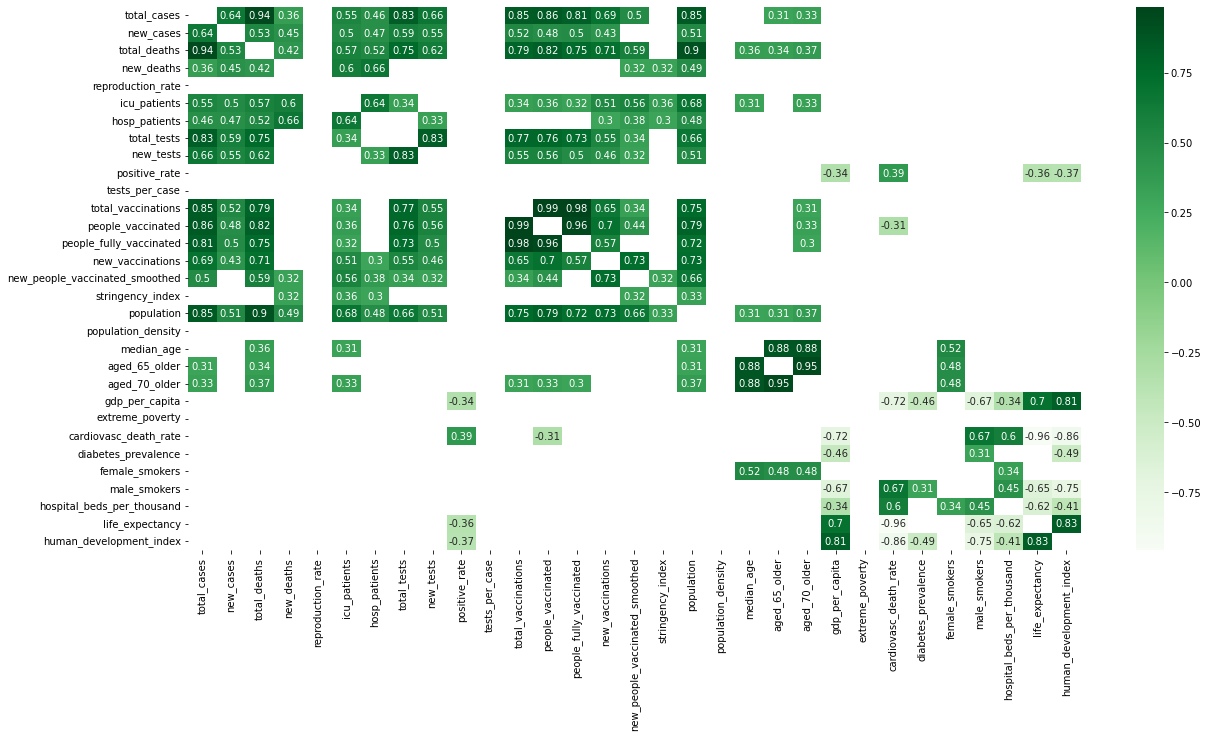

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
corr_f = corr[((corr >= .3) | (corr <= -.3)) & (corr != 1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(corr_f, annot=True, cmap="Greens")
plt.show()

In [32]:
def draw_histograms(df, cols, n_rows, n_cols):
    fig = plt.figure()
    for i, col in enumerate(cols):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[col].hist(bins=10,ax=ax)
        ax.set_title(col.replace("_", " ").title())
    fig.tight_layout()
    plt.show()

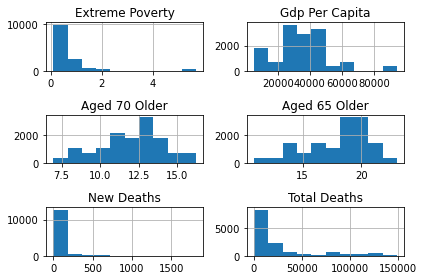

In [33]:
draw_histograms(df, ['extreme_poverty', 'gdp_per_capita', 'aged_70_older', 
                     'aged_65_older', 'new_deaths', 'total_deaths'], 
                     3, 2)

In [34]:
def draw_scatterplots(df, cols, n_rows, n_cols):
    fig = plt.figure()
    for i, col in enumerate(cols):
        ax=fig.add_subplot(n_rows,n_cols,i+1)    
        sns.scatterplot(x=df[col], y=df['total_deaths'], ax=ax, color='red')
        plt.ylabel("Total Deaths")
        plt.xlabel(col.replace("_", " ").title())
    fig.tight_layout()
    plt.show()

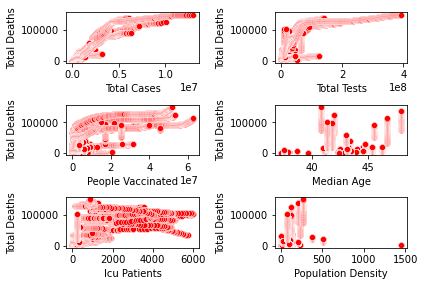

In [35]:
draw_scatterplots(df, ['total_cases', 'total_tests', 
                       'people_vaccinated','median_age', 'icu_patients', 'population_density'],
                       3, 2)

In [36]:
#sns.pairplot(df, diag_kind='kde')
#plt.show()

### Simple Linear Regression Models
Based on the data we visualized starting in [the visualization section](###Data-Visualization) lets compute simple linear regression models for some of our input variables:

In [37]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Strong correlation between total deaths and total cases. 
# There is 0.0169 time increate in total deaths given the 1 unit increate in total cases.
results = ols("total_deaths ~ total_cases", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 1.112e+05
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:27:39   Log-Likelihood:            -1.4961e+05
No. Observations:               13870   AIC:                         2.992e+05
Df Residuals:                   13868   BIC:                         2.992e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1230.6549    121.958     10.091      

In [38]:
results = ols("total_deaths ~ total_cases + total_tests", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 5.809e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:27:39   Log-Likelihood:            -1.4934e+05
No. Observations:               13870   AIC:                         2.987e+05
Df Residuals:                   13867   BIC:                         2.987e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1047.3744    119.874      8.737      

In [39]:
results = ols("total_deaths ~ people_vaccinated", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                 2.779e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:27:39   Log-Likelihood:            -1.5724e+05
No. Observations:               13870   AIC:                         3.145e+05
Df Residuals:                   13868   BIC:                         3.145e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8091.0237    199.28

In [40]:
results = ols("total_deaths ~ total_cases + total_tests + people_vaccinated", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                 3.913e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:27:39   Log-Likelihood:            -1.4928e+05
No. Observations:               13870   AIC:                         2.986e+05
Df Residuals:                   13866   BIC:                         2.986e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1088.4197    119.37

In [41]:
results = ols("total_deaths ~ total_cases + new_cases + new_deaths + total_tests + new_tests + total_vaccinations\
             + people_vaccinated + new_vaccinations + stringency_index + population + population_density + median_age\
             + aged_65_older + aged_70_older + gdp_per_capita + extreme_poverty + cardiovasc_death_rate + diabetes_prevalence\
             + female_smokers + male_smokers + hospital_beds_per_thousand + life_expectancy + human_development_index", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 1.292e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:27:39   Log-Likelihood:            -1.4328e+05
No. Observations:               13870   AIC:                         2.866e+05
Df Residuals:                   13846   BIC:                         2.868e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Model Building and Evaluation
We can tackle this problem with a supervised regression technique as we are looking for the number of COVID-19 deaths based on many other internal and external factors in the dataset.  Visually and statistically, there is a linear relationship between the dependent variable (total deaths) and the independent variables. Earlier in the data exploration part, we applied the Linear Regression model and visualised the data with a pair plot to see the correlation between variables. We noted a strong relationship between the dependent variable and the independent variables. However, we also noted a strong correlation between a few independent variables. In this case, we could apply the feature selection technique to remove the variables. However, we do not remove anything; instead, we try the Lasso Regression because it can help to zero the least important features.

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

### Pipeline
We seperated the independent variables and the target variable in two seperate lists. 

In [43]:
dep_var = ['total_deaths']

ind_vars = list(df.columns)
ind_vars.remove('total_deaths')

Because linear regression algorithms expect data to have a gaussian distribution, we normalize our features individually to eliminate varying scales. Since the total deaths and other variables such as cases and tests are always positive numbers, with no bell curve or normal distribution, we will apply normalization (MinMax) scaling technique.

In [44]:
num_si_step = ('si', SimpleImputer(strategy='median'))
num_scl_step = ('scl', MinMaxScaler())
num_steps = [num_si_step, num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformer = [('num', num_pipe, ind_vars)]

In [45]:
ct = ColumnTransformer(transformers=num_transformer)
ct.fit(df[ind_vars])
X = ct.transform(df[ind_vars])
y = df[['total_deaths']].values

## **First Approach**: Hyperparameter Tuning for Decision Tree Regressor
 
Since Decision Tree Regressor is the best performer compared to the other models regarding the cross-validation method, we choose Decision Tree Regressor in this case for hyperparameter tuning. We use the Grid Search method to search for the best hyperparameter and then use the hyperparameters we got from the search and apply them to the model. After, we will compare the result of the before and after-tuned hyperparameter models. From our development, we see that the model after the hyperparameter is tuned gives better results regarding the RMSE score from both hold-out and cross-validation evaluation.  

### Train-Test Split (80-20) -- Regularization

In [46]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11096, 30) (2774, 30) (11096, 1) (2774, 1)


### Linear Regression

In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression model RMSE, MSE, R2 results
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
# results based on test data
y_pred = reg.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

RMSE:7064.5436403076055
Mean Squared Error:49907776.84581063
R2:0.9589910139299496


In [48]:
# Linear regression results based on train data
y_train_pred = reg.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:7138.763721747759
Mean Squared Error:50961947.47494191
R2:0.9589129226026707


### Elastic Net

In [49]:
# Elastic Net model RMSE, MSE, R2 results
from sklearn.linear_model import ElasticNet

enr = ElasticNet()
enr.fit(X_train, y_train)
y_pred = enr.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

RMSE:36280.82875065644
Mean Squared Error:683482291.6436001
R2:0.4383858078124082


In [50]:
# Elastic Net results based on train data
y_train_pred = enr.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:36601.404051881764
Mean Squared Error:698959805.1265999
R2:0.4364772730677209


### Lasso Regression

In [51]:
# Lasso Regression model and RMSE, MSE results
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=10)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

RMSE:48942.192804157065
Mean Squared Error:51343015.627559856
R2:0.9578116849570364


In [52]:
# Lasso regression results based on train data
y_train_pred = lasso_reg.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:49177.35139422539
Mean Squared Error:52157080.74892002
R2:0.957949369682088


### SGD Regressor

In [53]:
# SGD Regressor odel and RMSE, MSE, R2 results
from sklearn.linear_model import SGDRegressor

clf = SGDRegressor(tol=1e-3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE:48872.17986351375
Mean Squared Error:54291761.04837855
R2:0.9553887146800779


In [54]:
# SGD regression results based on train data
y_train_pred = clf.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:49127.89234794255
Mean Squared Error:54317780.53696941
R2:0.9562073475690667


### Decision Tree Regressor (MAIN)

In [55]:
# Decision Tree Regressor and RMSE, MSE results -- best performing model for approach 1
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

RMSE:48942.192804157065
Mean Squared Error:51343015.627559856
R2:0.9578116849570364


In [56]:
# get importance
importance = dtr.feature_importances_
# summarize feature importance
for a,b in zip(ind_vars, importance):
	print(a, b)

total_cases 0.8852501698574777
new_cases 3.983187144297263e-05
new_deaths 8.874972231091095e-06
reproduction_rate 0.000156513914505177
icu_patients 0.000399989701165489
hosp_patients 0.0003002324287967466
total_tests 0.06351389493622536
new_tests 2.211673198813477e-06
positive_rate 0.0005258954633039338
tests_per_case 9.84476617007942e-05
total_vaccinations 0.000548713198110448
people_vaccinated 0.0004171173893642415
people_fully_vaccinated 0.0031206106320955653
new_vaccinations 1.2616802178908916e-05
new_people_vaccinated_smoothed 0.0003577320608525547
stringency_index 0.00029733599096090337
population 0.02653258583222634
population_density 0.0006733906565448721
median_age 0.00018369601459456442
aged_65_older 0.00020845631504816644
aged_70_older 0.0031902044481217917
gdp_per_capita 0.0001456320826275936
extreme_poverty 0.0020990705875460476
cardiovasc_death_rate 8.41572125729315e-05
diabetes_prevalence 1.7620388737348753e-06
female_smokers 0.0016700563732560487
male_smokers 0.00521693

In [57]:
# Decision Tree regression results based on train data
y_train_pred = dtr.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:49806.42621478479
Mean Squared Error:0.0
R2:1.0


### Random Forest Regressor

In [58]:
# Random Forest and RMSE, MSE, R2 results
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("RMSE:" + str(rmse(y_test, y_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_test, y_pred)))
print("R2:" + str(r2_score(y_test, y_pred)))

/tmp/ipykernel_2822/1045160469.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RMSE:49052.70970037126
Mean Squared Error:17417661.78019576
R2:0.9856879890377875


In [59]:
# Random Forest regression results based on train data
y_train_pred = rfr.predict(X_train)
print("RMSE:" + str(rmse(y_train, y_train_pred)))
print("Mean Squared Error:" + str(mean_squared_error(y_train, y_train_pred)))
print("R2:" + str(r2_score(y_train, y_train_pred)))

RMSE:49533.026665418634
Mean Squared Error:15235348.6137805
R2:0.9877167969693958


### Cross validation
We apply cross-validation with k=5 folds to estimate the performance of the machine learning model on unseen data (non-training data). The Decision Tree Regressor is the best performer in terms of MSE while linear regression is the worst performer in terms of the RMSE score.

In [60]:
from sklearn.model_selection import cross_val_score

# result for Linear Regression with cross valisation and RMSE scores, mean, standard deviation
def display_scores(scores):
    print("Scores:", np.sqrt(-scores))
    print("Mean:", np.sqrt(-scores).mean())
    print("Standard deviation:", np.sqrt(-scores).std())

### Linear Regression

In [61]:
reg = LinearRegression()
#scores = cross_val_score(reg, X, y, np.ravel(y), cv=5,scoring='neg_mean_squared_error')
scores = cross_val_score(reg, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [13752.52130363 11688.38733639 12599.55886119 30235.38296593
 13180.05915096]
Mean: 16291.181923619471
Standard deviation: 7005.403974159398


### Elastic Net

In [62]:
# result for ElasticNet with cross validation and RMSE scores, mean, standard deviation
enr = ElasticNet()
scores = cross_val_score(enr, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [13964.0081663  30336.13582157 31123.46956271 19256.77729951
 39416.09996319]
Mean: 26819.29816265587
Standard deviation: 9077.705182016809


### Lasso Regression

In [63]:
# result for Lasso Regression with cross validation and RMSE scores, mean, standard deviation
lasso_reg = Lasso(alpha=10)
scores = cross_val_score(lasso_reg, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [12936.12603374 10214.45587422 12511.49416854 27743.25905593
 11698.83801519]
Mean: 15020.834629521833
Standard deviation: 6428.682929017835


### SGD Regressor

In [64]:
# result for SGD Regressor with cross validation and RMSE score, mean, standard deviation
clf = SGDRegressor(max_iter=1000, tol=1e-3)
scores = cross_val_score(clf, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was 

Scores: [14239.8114593   9773.72297    12282.3826091  28045.37540358
 11911.32533202]
Mean: 15250.523554799234
Standard deviation: 6552.636459663921


### Decision Tree Regressor

In [65]:
# result for Decision Tree Regressor with cross validation and RMSE score, mean, standard deviation
dtr = DecisionTreeRegressor()
scores = cross_val_score(dtr, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [11485.45539123 24875.82990205 12069.12422207 10141.45873407
 17278.23036832]
Mean: 15170.019723549009
Standard deviation: 5424.4870024515285


### Random Forest Regressor

In [66]:
# result for Random Forest Regressor with cross validation and RMSE score, mean, standard deviation
rfr = RandomForestRegressor(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
scores = cross_val_score(rfr, X, y, cv=5,scoring='neg_mean_squared_error')
display_scores(scores)

/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn

Scores: [ 6277.96064252  9116.84142488 10137.15370729 10552.86821662
 11470.89591344]
Mean: 9511.143980950805
Standard deviation: 1784.7495176165842


We do the hold-out method by splitting the data into train-test sets of 80-20 for all the chosen models above. Then we compare the RMSE, MSE, and R2 of each model. We noted that Linear Regression is the best performer in this case.
 
However, we apply cross-validation with k=5 folds. The Decision Tree Regressor is the best performer with an average slightest error, while Linear regression worst performer, in relation to the RMSE score.
 
Additionally, the Linear Regression model seems to be overfitting when we apply the hold-out method of train-test of 80-20. The training performance gives better results than the testing performance.


### Hyperparameter Tuning and Validation

Since Decision Tree Regressor is the best performer compared to the other models regarding the cross-validation method, we choose Decision Tree Regressor in this case for hyperparameter tuning. We use the Grid Search method to search for the best hyperparameter and then use the hyperparameters we got from the search and apply them to the model. After, we will compare the result of the before and after-tuned hyperparameter models. From our development, we see that the model after the hyperparameter is tuned gives better results regarding the RMSE score from both hold-out and cross-validation evaluation.  

In [67]:
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# Hyper parameters range intialization for tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

# calculating different regression metrics
tuning_model=GridSearchCV(dtr,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

# function for calculating how much time take for hyperparameter tuning
def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [68]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [69]:
%%capture

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)

In [70]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 30,
 'min_samples_leaf': 6,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [71]:
# best model score
tuning_model.best_score_

-0.00038767877873292127

In [72]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=5,max_features='auto',max_leaf_nodes=50,min_samples_leaf=2,min_weight_fraction_leaf=0.1,splitter='random')

In [73]:
# fitting model
tuned_hyper_model.fit(X_train,y_train)

/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


DecisionTreeRegressor(max_depth=5, max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=2, min_weight_fraction_leaf=0.1,
                      splitter='random')

In [74]:
# prediction 
tuned_pred=tuned_hyper_model.predict(X_test)

### Evaluating the Performance of Our Model

The Linear regression model seem to be overfitting when the testing data create more error than training data.


In [75]:
from sklearn import metrics

# Decision tree regressor with MAE, MSE, RMSE results, with hyperparameter tuned 
print('MAE:', metrics.mean_absolute_error(y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)))

# Decsion Tree Regressor with cross validation RMSE score, standard deviaton, with hyperparameter tuned
scores = cross_val_score(tuned_hyper_model, X, y, cv=3, scoring='neg_mean_squared_error')
display_scores(scores)

MAE: 11112.628652665366
MSE: 360809508.0410812
RMSE: 18994.986392232062
Scores: [0.0347935  0.02353116 0.01710816]
Mean: 0.02514427429773922
Standard deviation: 0.007309557173304203


/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/kontos/anaconda3/envs/dsenv/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


## **2nd Approach:** Tensorflow Neural Network

### Let's develop a Baseline Neural Network Model using a simple model that has:
- A single fully connected hidden layer with the same number of neurons (i.e. 27) as input attributes
- A ReLU activation function
- A batch normalization layer between two dense layers
- Adaptive Moment Estimation (Adam) momentum optimizer

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np

import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential 
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler

In [77]:
tf.random.set_seed(45)

#define baseline model
model = keras.models.Sequential([
    keras.layers.Dense(30, input_shape=(30,), activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer= tf.keras.optimizers.Adam(0.02))

#fit model
history = model.fit(X_train, y_train, epochs= 300)
model.summary()

#test model
print(model.predict(X_test))

Epoch 1/300


2022-10-23 01:43:45.656266: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 01:43:45.657990: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


347/347 [==============================] - 2s 4ms/step - loss: 1751063552.0000
Epoch 2/300
347/347 [==============================] - 1s 4ms/step - loss: 1197268352.0000
Epoch 3/300
347/347 [==============================] - 1s 3ms/step - loss: 578409856.0000
Epoch 4/300
347/347 [==============================] - 1s 3ms/step - loss: 252041328.0000
Epoch 5/300
347/347 [==============================] - 1s 2ms/step - loss: 136795744.0000
Epoch 6/300
347/347 [==============================] - 1s 3ms/step - loss: 108270256.0000
Epoch 7/300
347/347 [==============================] - 1s 4ms/step - loss: 98678824.0000
Epoch 8/300
347/347 [==============================] - 1s 3ms/step - loss: 77406944.0000
Epoch 9/300
347/347 [==============================] - 1s 3ms/step - loss: 70340168.0000
Epoch 10/300
347/347 [==============================] - 1s 3ms/step - loss: 74532984.0000
Epoch 11/300
347/347 [==============================] - 1s 3ms/step - loss: 74638336.0000
Epoch 12/300
347/347 [=

In [78]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


### Automatic Hyperparamater Tuning

In [79]:
def model_builder(hp):
  # Initialize the Sequential API and start stacking the layers
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=30, max_value=30)
  model = keras.models.Sequential([
      keras.layers.Dense(input_shape=(30,), units=hp_units, activation='relu'),
      # Add next layers
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1)
  ])
      # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[2e-1, 2e-2, 2e-3, 2e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['accuracy'])
  return model

In [80]:
tf.random.set_seed(45)

# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=300,
)

# Perform hypertuning
tuner.search(X_train, y_train, epochs=300, validation_split=0.2)
best_hp=tuner.get_best_hyperparameters()[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [81]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)

In [82]:
h_model.fit(X_train, y_train, epochs=300)
h_model.summary()
print(h_model.predict(X_test))

Epoch 1/300
347/347 [==============================] - 1s 2ms/step - loss: 1858345088.0000 - accuracy: 0.0000e+00
Epoch 2/300
347/347 [==============================] - 1s 3ms/step - loss: 1858015488.0000 - accuracy: 0.0000e+00
Epoch 3/300
347/347 [==============================] - 1s 2ms/step - loss: 1857639680.0000 - accuracy: 0.0000e+00
Epoch 4/300
347/347 [==============================] - 1s 2ms/step - loss: 1857226752.0000 - accuracy: 0.0000e+00
Epoch 5/300
347/347 [==============================] - 1s 4ms/step - loss: 1856762880.0000 - accuracy: 0.0000e+00
Epoch 6/300
347/347 [==============================] - 1s 3ms/step - loss: 1856273280.0000 - accuracy: 0.0000e+00
Epoch 7/300
347/347 [==============================] - 1s 2ms/step - loss: 1855737984.0000 - accuracy: 0.0000e+00
Epoch 8/300
347/347 [==============================] - 1s 3ms/step - loss: 1855111424.0000 - accuracy: 0.0000e+00
Epoch 9/300
347/347 [==============================] - 1s 3ms/step - loss: 1854476416.00

### Hyperparameter Tuning 
Some experiments and parameter hypertuning that were done to try and get better results were:
* Making the model Deeper by adding another layer, 2 layers instead of 1
* Making the model wider by adding more neurons, adding up to 128 in the first layer
* Changing the Adam optimizer to rmsprop. Increasing and Decreasing the Adam optimizer
* Increasing the training time from 300 to 600 epoch

All of these experiments did not lead to better results. These experiments were all also done using the preprocessed data and still do not give better results. So the baseline model with preprocessed data was chosen to be the Main Model. 

In [83]:
# Hyperparameter Tuning
# importing matplotlib module 
import matplotlib.pyplot as plt

X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

#build model 1
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

#fit model
history = model.fit(X_train, y_train, epochs= 100, validation_data=(x_val, y_val))

model.summary()


#evaluate the model
print(model.predict(X_test))

Epoch 1/100
330/330 [==============================] - 3s 8ms/step - loss: 1858772608.0000 - val_loss: 1816262784.0000
Epoch 2/100
330/330 [==============================] - 3s 10ms/step - loss: 1853294848.0000 - val_loss: 1808239488.0000
Epoch 3/100
330/330 [==============================] - 3s 8ms/step - loss: 1844590976.0000 - val_loss: 1797255936.0000
Epoch 4/100
330/330 [==============================] - 2s 7ms/step - loss: 1832788480.0000 - val_loss: 1782207872.0000
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 1818103808.0000 - val_loss: 1765965824.0000
Epoch 6/100
330/330 [==============================] - 3s 10ms/step - loss: 1800674816.0000 - val_loss: 1746328064.0000
Epoch 7/100
330/330 [==============================] - 3s 9ms/step - loss: 1780980480.0000 - val_loss: 1727550848.0000
Epoch 8/100
330/330 [==============================] - 2s 7ms/step - loss: 1759195776.0000 - val_loss: 1708098816.0000
Epoch 9/100
330/330 [=========================

In [84]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


In [85]:
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

#build model 2
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

#fit model
history = model.fit(X_train, y_train, epochs= 100, validation_data=(x_val, y_val))

model.summary()

#evaluate the model
print(model.predict(X_test))

Epoch 1/100
313/313 [==============================] - 3s 7ms/step - loss: 1868411648.0000 - val_loss: 1676200064.0000
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 1863479680.0000 - val_loss: 1669276672.0000
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 1855660544.0000 - val_loss: 1659377664.0000
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 1845032832.0000 - val_loss: 1647882752.0000
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 1831665280.0000 - val_loss: 1635313920.0000
Epoch 6/100
313/313 [==============================] - 2s 6ms/step - loss: 1815789056.0000 - val_loss: 1618840192.0000
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 1798038016.0000 - val_loss: 1604456320.0000
Epoch 8/100
313/313 [==============================] - 2s 7ms/step - loss: 1777943808.0000 - val_loss: 1582387456.0000
Epoch 9/100
313/313 [===========================

In [86]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


In [87]:
#build model 3
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="tanh"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="tanh"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', 
              optimizer='adam')

#fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs= 100, 
                    validation_data=(x_val, y_val))

model.summary()

#evaluate the model
print(model.predict(X_test))

Epoch 1/100
313/313 [==============================] - 3s 6ms/step - loss: 1868375552.0000 - val_loss: 1675928960.0000
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 1863719424.0000 - val_loss: 1668081024.0000
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 1856113408.0000 - val_loss: 1658908800.0000
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 1845645440.0000 - val_loss: 1648431616.0000
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 1832390144.0000 - val_loss: 1631388544.0000
Epoch 6/100
313/313 [==============================] - 2s 6ms/step - loss: 1816586496.0000 - val_loss: 1618997120.0000
Epoch 7/100
313/313 [==============================] - 1s 5ms/step - loss: 1798952576.0000 - val_loss: 1600019584.0000
Epoch 8/100
313/313 [==============================] - 1s 5ms/step - loss: 1778950144.0000 - val_loss: 1582179712.0000
Epoch 9/100
313/313 [===========================

In [88]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


In [89]:
#build model 4
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', 
              optimizer='rmsprop')

#fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs= 100, 
                    validation_data=(x_val, y_val))

model.summary()

#evaluate the model
print(model.predict(X_test))

Epoch 1/100
313/313 [==============================] - 3s 6ms/step - loss: 1868491904.0000 - val_loss: 1676321024.0000
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 1865148928.0000 - val_loss: 1671971328.0000
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 1860470144.0000 - val_loss: 1665859200.0000
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 1854497536.0000 - val_loss: 1659316224.0000
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 1846978944.0000 - val_loss: 1654308352.0000
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 1838069632.0000 - val_loss: 1644428544.0000
Epoch 7/100
313/313 [==============================] - 2s 6ms/step - loss: 1828041984.0000 - val_loss: 1634678144.0000
Epoch 8/100
313/313 [==============================] - 2s 6ms/step - loss: 1816370688.0000 - val_loss: 1622032000.0000
Epoch 9/100
313/313 [===========================

In [90]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


In [91]:
# MAIN MODEL 
# evaluate model with standardized dataset
from sklearn import preprocessing
# preprocess the data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.reshape(-1,1)
y_test = y_test


tf.random.set_seed(42)

#define baseline model
model = keras.models.Sequential([
    keras.layers.Dense(units= 30, 
                       input_shape= (30,), 
                       activation= "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', 
              optimizer= tf.keras.optimizers.Adam(0.02))

#fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs= 300)

model.summary()

#test model
print(model.predict(X_test))


Epoch 1/300
313/313 [==============================] - 2s 5ms/step - loss: 1765815552.0000
Epoch 2/300
313/313 [==============================] - 2s 5ms/step - loss: 1226368384.0000
Epoch 3/300
313/313 [==============================] - 2s 5ms/step - loss: 586272192.0000
Epoch 4/300
313/313 [==============================] - 1s 5ms/step - loss: 225612944.0000
Epoch 5/300
313/313 [==============================] - 1s 3ms/step - loss: 129806144.0000
Epoch 6/300
313/313 [==============================] - 1s 5ms/step - loss: 96830448.0000
Epoch 7/300
313/313 [==============================] - 1s 4ms/step - loss: 78311072.0000
Epoch 8/300
313/313 [==============================] - 1s 4ms/step - loss: 74567248.0000
Epoch 9/300
313/313 [==============================] - 1s 3ms/step - loss: 75838520.0000
Epoch 10/300
313/313 [==============================] - 1s 4ms/step - loss: 74541040.0000
Epoch 11/300
313/313 [==============================] - 1s 5ms/step - loss: 72087792.0000
Epoch 12/300

In [92]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


In [93]:
#define model 6 
model = keras.models.Sequential([
    keras.layers.Dense(30, input_shape=(30,), activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer= tf.keras.optimizers.Adam(0.01))

#fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs= 300)

model.summary()

#test model
print(model.predict(X_test))

Epoch 1/300
313/313 [==============================] - 2s 4ms/step - loss: 1841843328.0000
Epoch 2/300
313/313 [==============================] - 1s 4ms/step - loss: 1680333952.0000
Epoch 3/300
313/313 [==============================] - 1s 4ms/step - loss: 1399853568.0000
Epoch 4/300
313/313 [==============================] - 1s 5ms/step - loss: 1066661312.0000
Epoch 5/300
313/313 [==============================] - 1s 3ms/step - loss: 753653056.0000
Epoch 6/300
313/313 [==============================] - 1s 3ms/step - loss: 491911584.0000
Epoch 7/300
313/313 [==============================] - 1s 3ms/step - loss: 305711712.0000
Epoch 8/300
313/313 [==============================] - 1s 3ms/step - loss: 195472720.0000
Epoch 9/300
313/313 [==============================] - 1s 3ms/step - loss: 145372464.0000
Epoch 10/300
313/313 [==============================] - 1s 4ms/step - loss: 119306272.0000
Epoch 11/300
313/313 [==============================] - 1s 5ms/step - loss: 108211864.0000
Epoc

In [94]:
print(y_test)

[[25005.]
 [ 9664.]
 [ 6053.]
 ...
 [12549.]
 [ 1204.]
 [13000.]]


## Discussion -- Interpretations and Implications

Although we were unable to get feature importance for our neural network. We successfully retrieved feature importance for the inital approach. What we find is that features related to vaccinations, testing, and population are the best predictors of total deaths. 

As a global health organization, our job is to use these results to inform both research and practice. These results indicate that we should be shifting resources towards providing more means of testing and vaccinations to the public. 
In terms of research, we can minimize deaths from COVID-19 by optimizing the effectiveness of vaccines and the precision/accuracy of tests.

Policymakers (us)
    - Our goal is to maximize the health our patients leveraging whatever resources we have. Our results reinforce some assumptions the lay public already has about COVID-19, namely that social-distancing, vaccination, and testing prevents COVID-19 death. Thus our best route of action is to architect more social distancing initiatives, pop-up vaccination booths, and meet demand of testing kits.


 




## Challenges
- Feature selection/engineering
    - **Outliers**

    One of the issues we faced in our project is the detection and removal of outliers. We constructed multiple functions to identify outliers (i.e., through IQR or mean/median comparison). These functions returned a fairly significant amount of outliers in some of our columns; however, this is expected, and we did not transform or remove these values. The reason we kept these "outliers" in our dataset is because they were less indicative of "outliers" and more indicative of the diversity of the dataset. For example, a country like Haiti has much weaker infrastructure and less organization than a country such as the U.S.A. As a result, Haitian records may contain many outliers under the lower bound for 'total tests' while American records could contain many outliers over the upper bound for 'total tests' because Haiti probably has less access to testing kits than America does.

    - **Null Values**

    Another big issue with our dataset concerns null values. We had to actually fill the total deaths of an entire country in our dataset because the data was missing. This hurts the performance of our model because the toal deaths for those records is not actually associated with any of the other non-filled input variable values for that country. This problem is circumvented in our 2nd notebook with an alternate dataset because we chose countries that we can expect to have minimal null values (as they did).


- Hyperparameter tuning
    - **Vanishing Gradients vs Dying ReLUs**
    
    Because the gradient for ReLU is either 0 or 1 it can never saturate and our gradients never vanish. The caveat to this is that we can get dead ReLUs -- our neurons will only output 0 and as a result never learn because the gradient is never transferred. We could have potentially solved this problem by using some variant of leaky ReLU; however, leaky ReLU is slower when making predictions and we would have to reevaluate how much time we are willing to sacrifice for a performance boost.

- Diverse data vs quality data

In this notebook we decided to use a set of countries we thought were representative of the world population -- in other words, a set of countries where the input variables cover a diverse/wide range of values. Had we not chosen a diverse enough subset of data, our machine learning algorithms would result in overfitting. What this means is that the model will have decreased generalizability; it will produce very good results on training data, but it will perform poorly on unseen data. Because we are interpreting this model from the perspective of a global health organization, we will be introducing bias to our results by selecting nations based on featuresf that we will at the same time be feeding into our models.

We have provided an additional notebook that replaces the countries selected with USA, Canada, Australia, and the majority of European countries. What we find is that their are significantly less null values in this dataset (e.g., higher reliability/quality), but it is not representative of the global population. This means that our interpretations are limited to health policy in those countries (e.g., 'Western' nations) as opposed to the global population, but the interpretations can be made with more confidence due to less filled datapoints and more data in general. 